##### Kaggle Kernel for Quora Question Pairs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from IPython.display import display
pd.set_option('display.max_colwidth',-1)
import os
import gc

pal = sns.color_palette()

In [2]:
df = pd.read_csv("train.csv").fillna("")
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


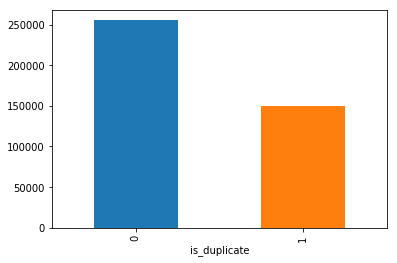

In [3]:
df.groupby("is_duplicate")['id'].count().plot.bar()

#### FEATURE CONSTRUCTION

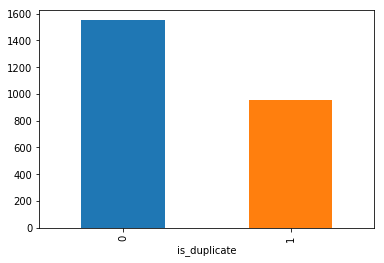

In [4]:
dfs = df[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

In [5]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

Transform questions by TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31365 stored elements in Compressed Sparse Row format>

In [7]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

EDA

In [8]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,76,39,13,7,0.100000


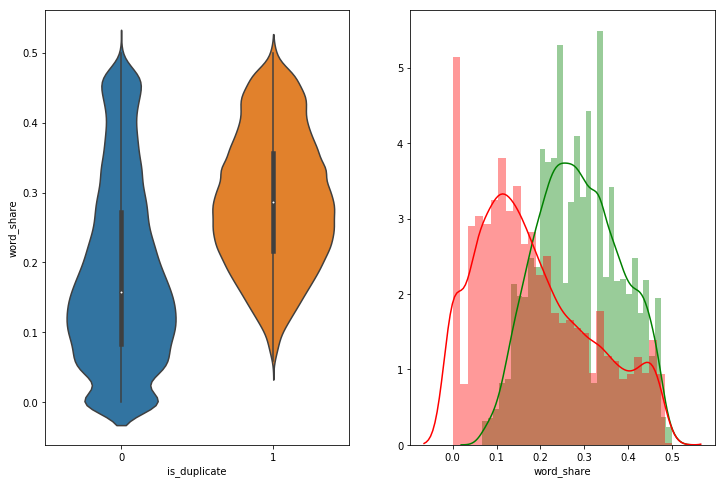

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

In [10]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

In [11]:
from IPython.display import display, HTML

df_subsampled['q_n_words_avg'] = np.round((df_subsampled['q1_n_words'] + df_subsampled['q2_n_words'])/2.0).astype(int)
print(df_subsampled['q_n_words_avg'].max())
df_subsampled = df_subsampled[df_subsampled['q_n_words_avg'] < 20]
df_subsampled.head()

39


C:\Users\Naaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,q_n_words_avg
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,66,57,14,12,0.434783,13
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,51,88,8,13,0.200000,10
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,73,59,14,10,0.166667,12
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,50,65,11,9,0.000000,10
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,76,39,13,7,0.100000,10


In [12]:
word_lens = sorted(list(df_subsampled['q_n_words_avg'].unique()))
# make figure
figure = {
    'data': [],
    'layout': {
        'title': 'Scatter plot of char lenghts of Q1 and Q2 (size ~ word share similarity)',
    },
    'frames': []#,
    #'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0, 200], 'title': 'Q1 length'}
figure['layout']['yaxis'] = {
    'range': [0, 200],
    'title': 'Q2 length'#,
    #'type': 'log'
}
figure['layout']['hovermode'] = 'closest'

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Avg. number of words in both questions:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
word_len = word_lens[0]
dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]
data_dict = {
    'x': list(dff['q1len']),
    'y': list(dff['q2len']),
    'mode': 'markers',
    'text': list(dff['is_duplicate']),
    'marker': {
        'sizemode': 'area',
        #'sizeref': 200000,
        'colorscale': 'Portland',
        'size': dff['word_share'].values * 120,
        'color': dff['is_duplicate'].values,
        'colorbar': dict(title = 'duplicate')
    },
    'name': 'some name'
}
figure['data'].append(data_dict)

# make frames
for word_len in word_lens:
    frame = {'data': [], 'name': str(word_len)}
    dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]

    data_dict = {
        'x': list(dff['q1len']),
        'y': list(dff['q2len']),
        'mode': 'markers',
        'text': list(dff['is_duplicate']),
        'marker': {
            'sizemode': 'area',
            #'sizeref': 200000,
            'size': dff['word_share'].values * 120,
            'colorscale': 'Portland',
            'color': dff['is_duplicate'].values,
            'colorbar': dict(title = 'duplicate')
        },
        'name': 'some name'
    }
    frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [word_len],
        {
            'frame': {'duration': 300, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 300}
        }
     ],
     'label': word_len,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]

py.iplot(figure)

### PARALLEL COORDINATES

C:\Users\Naaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Naaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.



Text(0,0.5,'value of dimension')

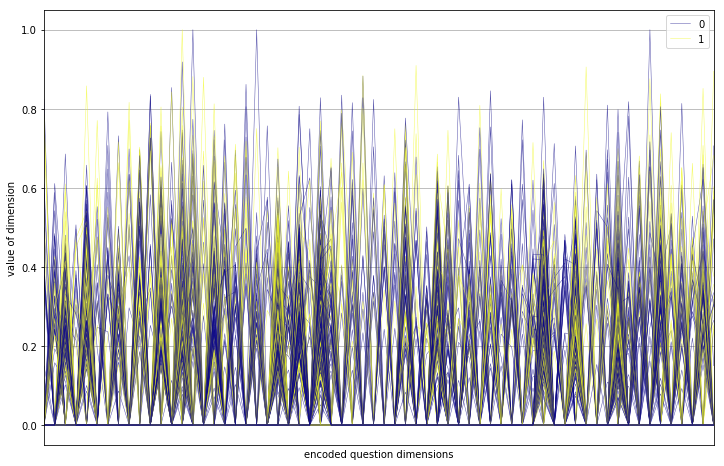

In [21]:
from pandas.tools.plotting import parallel_coordinates

df_subsampled = df[0:500]

N = 64

#encoded = HashingVectorizer(n_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
encoded = TfidfVectorizer(max_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
# generate columns in the dataframe for each of the 32 dimensions
cols = ['hashed_'+str(i) for i in range(encoded.shape[1])]
for idx, col in enumerate(cols):
    df_subsampled[col] = encoded[:,idx].toarray()

plt.figure(figsize=(12,8))
kws = {
    'linewidth': 0.5,
    'alpha': 0.7
}
parallel_coordinates(
    df_subsampled[cols + ['is_duplicate']],
    'is_duplicate',
    axvlines=False, colormap=plt.get_cmap('plasma'),
    **kws
)
#plt.grid(False)
plt.xticks([])
plt.xlabel("encoded question dimensions")
plt.ylabel("value of dimension")

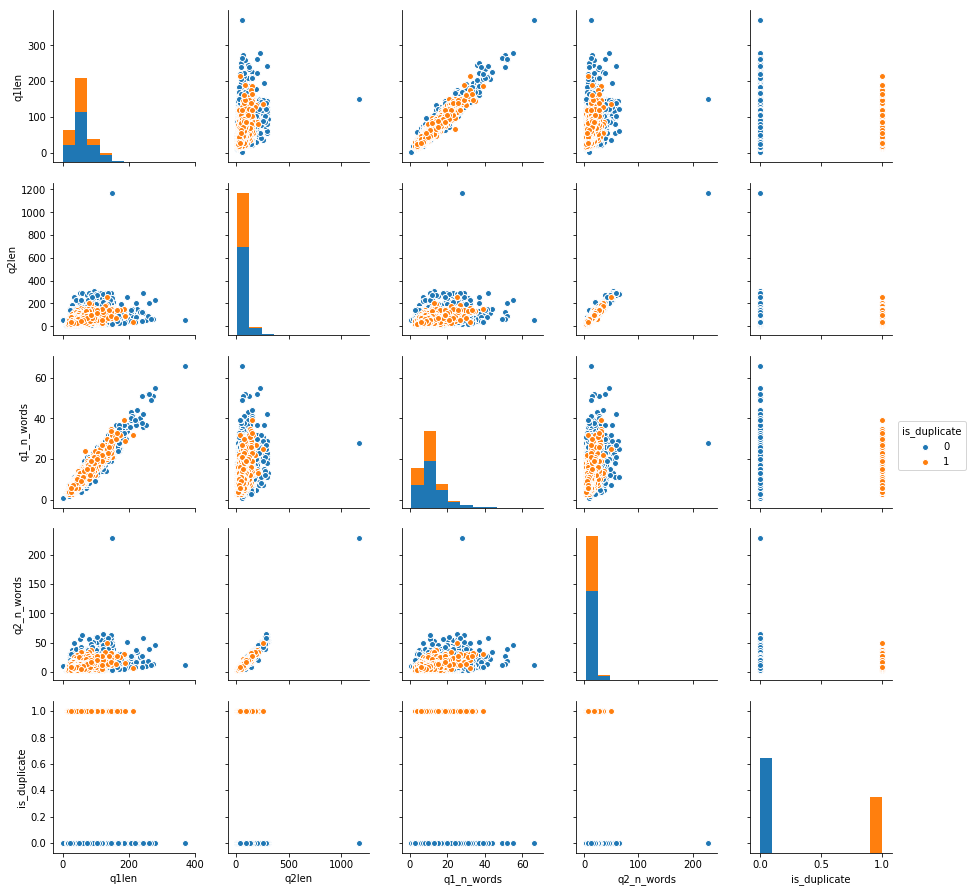

In [22]:
n = 10000
sns.pairplot(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270874, 5), (133416, 5), (270874,), (133416,))

In [14]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   20.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [15]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

6. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l1'}
5. Mean validation neg log loss: -0.690 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
3. Mean validation neg log loss: -0.582 (std: 0.001) - {'C': 0.001, 'penalty': 'l1'}
4. Mean validation neg log loss: -0.586 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.568 (std: 0.001) - {'C': 1.0, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.569 (std: 0.001) - {'C': 1.0, 'penalty': 'l2'}


In [16]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l1'}
[[-13.51197031   4.27945423  10.32519863 -13.02337872   3.29730272]]


C: 1e-06, parameters [[-0.00424654 -0.00232424 -0.00354647 -0.00199886 -0.00186031]] and intercept [-0.03324687]
C: 0.0001, parameters [[-0.16061857 -0.09048901 -0.13250978 -0.07998846  0.68641435]] and intercept [-0.70401556]
C: 1.0, parameters [[-10.2533974   -0.91965275   6.77946545  -7.16268415   3.29874476]] and intercept [-1.34016168]


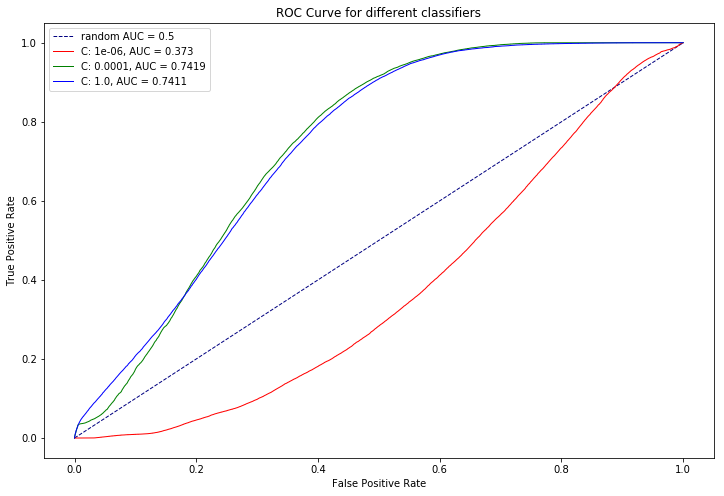

In [17]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

Text(0,0.5,'Precision')

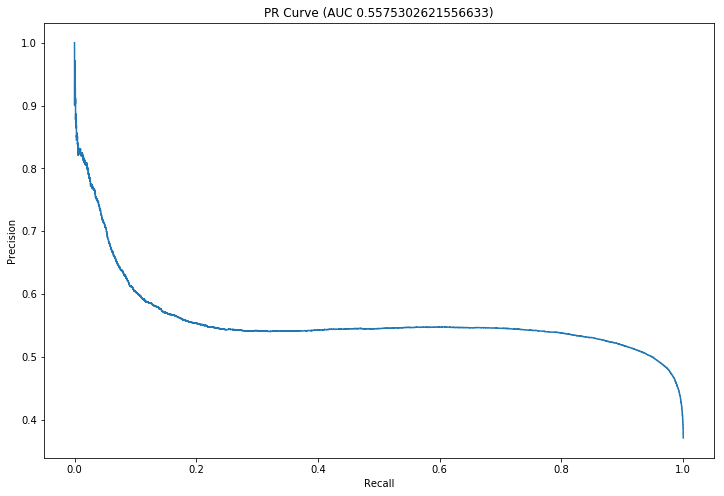

In [23]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

In [24]:
dftest = pd.read_csv("test.csv").fillna("")

dftest['q1len'] = dftest['question1'].str.len()
dftest['q2len'] = dftest['question2'].str.len()

dftest['q1_n_words'] = dftest['question1'].apply(lambda row: len(row.split(" ")))
dftest['q2_n_words'] = dftest['question2'].apply(lambda row: len(row.split(" ")))

dftest['word_share'] = dftest.apply(normalized_word_share, axis=1)

dftest.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,57,68,11,14,0.083333
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?,66,43,14,7,0.190476
2,2,What but is the best way to send money from China to the US?,What you send money to China?,60,29,14,6,0.222222
3,3,Which food not emulsifiers?,What foods fibre?,27,17,4,3,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,4,6,0.300000


In [25]:
retrained = cv.best_estimator_.fit(X, y)

X_submission = scaler.transform(dftest[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]

submission = pd.DataFrame({'test_id': dftest['test_id'], 'is_duplicate': y_submission})
submission.head()

,is_duplicate,test_id
0,0.227574,0
1,0.411078,1
2,0.477176,2
3,0.166794,3
4,0.611635,4


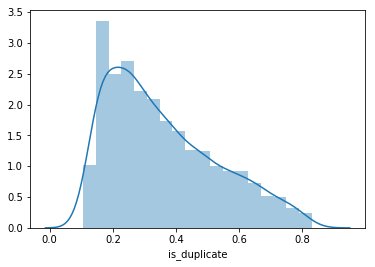

In [26]:
sns.distplot(submission.is_duplicate[0:2000])